In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [25]:
# 定义数据转换
transform = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))  # 将像素值归一化到[-1, 1]
])

# 加载训练和测试数据集
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


In [27]:
# for batch_idx, (data, _) in enumerate(train_loader):
#     print(data[0])
#     break 

In [28]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 4, stride=2, padding=1)  # 输出尺寸：16x16
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1)  # 输出尺寸：8x8
        self.relu2 = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)
        
    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.flatten(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar


In [29]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 64 * 7 * 7)
        self.relu = nn.ReLU()
        self.deconv1 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)  # 输出尺寸：14x14
        self.relu1 = nn.ReLU()
        self.deconv2 = nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1)  # 输出尺寸：28x28
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, z):
        x = self.fc(z)
        x = self.relu(x)
        x = x.view(-1, 64, 7, 7)
        x = self.relu1(self.deconv1(x))
        x = self.sigmoid(self.deconv2(x))
        return x


In [30]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar


In [31]:
def loss_function(recon_x, x, mu, logvar):
    # 重构损失
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # KL散度
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return BCE + KLD

In [38]:
latent_dim = 20  # 隐变量维度，可根据需要调整

model = VAE(latent_dim)
optimizer = optim.Adam(model.parameters(), lr=5e-4)


In [39]:
num_epochs = 20  # 训练轮数
log_interval = 100  # 打印日志的间隔

model.train()
train_losses = []

for epoch in range(1, num_epochs + 1):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print(f'Epoch [{epoch}/{num_epochs}] Batch [{batch_idx}/{len(train_loader)}] Loss: {loss.item() / len(data):.6f}')
    
    average_loss = train_loss / len(train_loader.dataset)
    train_losses.append(average_loss)
    print(f'====> Epoch: {epoch} Average loss: {average_loss:.4f}')


Epoch [1/20] Batch [0/469] Loss: 512.384399
Epoch [1/20] Batch [100/469] Loss: 223.313965
Epoch [1/20] Batch [200/469] Loss: 171.944504
Epoch [1/20] Batch [300/469] Loss: 148.601395
Epoch [1/20] Batch [400/469] Loss: 131.238373
====> Epoch: 1 Average loss: 184.6385
Epoch [2/20] Batch [0/469] Loss: 127.483200
Epoch [2/20] Batch [100/469] Loss: 121.238022
Epoch [2/20] Batch [200/469] Loss: 121.494141
Epoch [2/20] Batch [300/469] Loss: 109.451340
Epoch [2/20] Batch [400/469] Loss: 113.798203
====> Epoch: 2 Average loss: 119.1291
Epoch [3/20] Batch [0/469] Loss: 114.818619
Epoch [3/20] Batch [100/469] Loss: 117.102615
Epoch [3/20] Batch [200/469] Loss: 115.509346
Epoch [3/20] Batch [300/469] Loss: 109.671753
Epoch [3/20] Batch [400/469] Loss: 114.951164
====> Epoch: 3 Average loss: 111.8969
Epoch [4/20] Batch [0/469] Loss: 108.006393


KeyboardInterrupt: 

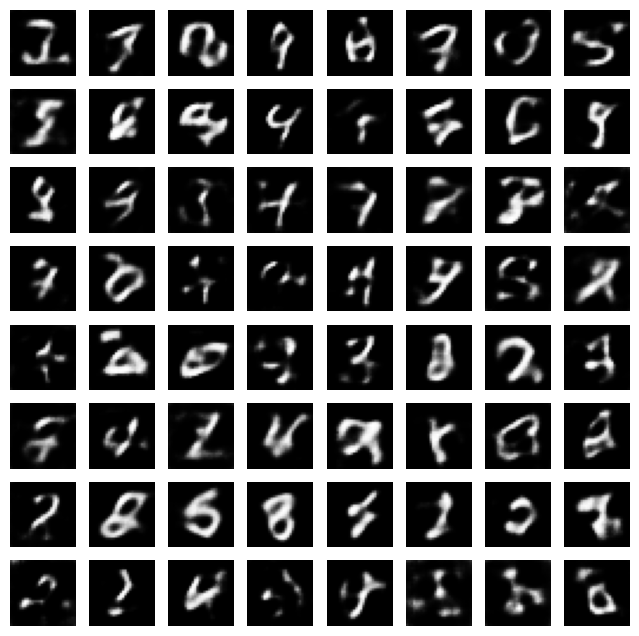

In [40]:
with torch.no_grad():
    # 从标准正态分布中采样隐变量
    sample = torch.randn(64, latent_dim)
    sample = model.decoder(sample)
    
    # 可视化生成的图像
    fig, axes = plt.subplots(8, 8, figsize=(8, 8))
    for i in range(8):
        for j in range(8):
            axes[i, j].imshow(sample[i * 8 + j].squeeze(0).numpy(), cmap='gray')
            axes[i, j].axis('off')
    plt.show()